In [14]:
import numpy as np
import sys
import re
import codecs
import os
import jieba
from gensim.models import word2vec
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from scipy import stats
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.metrics import f1_score
from bayes_opt import BayesianOptimization as BO
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [4]:
import gensim
from gensim.models import word2vec
import logging
import jieba
import numpy as np
model = gensim.models.KeyedVectors.load_word2vec_format("corpus_xueqiu.model.bin", binary=True)

def getWordVecs(wordList):
    vecs = []
    for word in wordList:
        word = word.replace('\r\n', '')
        try:
            vecs.append(model[word])
        except KeyError:
            continue
    # vecs = np.concatenate(vecs)
    return np.array(vecs, dtype = 'float')

def tingyongci_list_get():
    tingyongci_list = []
    with open("tingyonci.txt", 'r') as filename:
        file_list = filename.readlines()
        for line in file_list:
    #         print line[:-1].decode('gbk').encode('utf-8')
            line_utf8=line.replace('\r\n','').decode('gbk').encode('utf-8')
#             print len(line_utf8)
            tingyongci_list.append(unicode(line_utf8,encoding='utf-8'))
    return tingyongci_list

def parseSent(sentence,tingyongci_list):
    pop_list = []
    seg_list = jieba.cut(sentence)
    for i in seg_list:
        if not i in tingyongci_list:
             pop_list.append(i) #删除停用词
    output = ' '.join(pop_list)  # use space to join them
    return output


def buildVecs(filename,tingyongci_list):
    posInput = []
    with open(filename, "rb") as txtfile:
        # print txtfile
        for lines in txtfile:
            lines_s = lines.split('\r\n ')
            pop_list = []
            for line in lines_s:            
                line_s = jieba.cut(line)
                for i in line_s:
#                     print type(i)
                    if not i in tingyongci_list:
                         pop_list.append(i) #删除停用词
#                 print " ".join(pop_list)
                resultList = getWordVecs(pop_list)
                # for each sentence, the mean vector of all its vectors is used to represent this sentence
                if len(resultList) != 0:
                    resultArray = sum(np.array(resultList))/len(resultList)
                    posInput.append(resultArray)
    return posInput




# negInput = buildVecs('neg.txt')

# # use 1 for positive sentiment, 0 for negative
# y = np.concatenate((np.ones(len(posInput)), np.zeros(len(negInput))))

# X = posInput[:]
# for neg in negInput:
#     X.append(neg)
# X = np.array(X)



In [5]:
tingyongci_list = tingyongci_list_get()
posInput = buildVecs('./xueqiu——评论/pos/pos.1.txt',tingyongci_list)
print len(posInput[0])

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.705 seconds.
Prefix dict has been built succesfully.


400


In [6]:
# import os
# import re
# import codecs

with open("pos.txt",'w') as filename:
    fileDir = os.listdir("./xueqiu——评论/pos") #pos
    # csvfile = codecs.open("corpus.csv", 'a', 'utf-8')
    for file in fileDir:
        with open("./xueqiu——评论/pos/%s" % file, "r") as txtfile:
            for line in txtfile:
                filename.write("%s" % line)
                break
        
with open("neg.txt",'w') as filename:         
    fileDir = os.listdir("./xueqiu——评论/neg") #neg
    # csvfile = codecs.open("corpus.csv", 'w', 'utf-8')
    for file in fileDir:
        with open("./xueqiu——评论/neg/%s" % file, "r") as txtfile:
            for line in txtfile:
                filename.write("%s" % line)
                break




In [7]:
posInput = buildVecs('pos.txt',tingyongci_list)
negInput = buildVecs('neg.txt',tingyongci_list)
    

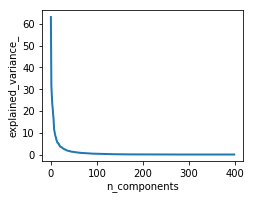

In [8]:

y = np.concatenate((np.ones(len(posInput)), np.zeros(len(negInput))))

X = posInput[:]
for neg in negInput:
    X.append(neg)
X = np.array(X)
X = scale(X)
from sklearn.decomposition import PCA

pca=PCA(n_components=400)
pca.fit(X)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

X_reduced = PCA(n_components = 100).fit_transform(X)

In [9]:
print len(posInput)
print len(negInput)
print len(X)

6994
2998
9992


In [10]:
pos_tran_num = int(0.8*len(posInput))
neg_tran_num = int(0.8*len(negInput))
print pos_tran_num
print neg_tran_num
x_train_pos = X_reduced[0:pos_tran_num]
x_train_neg = X_reduced[int(len(posInput)):(int(len(posInput))+neg_tran_num)]
x_test_pos = X_reduced[pos_tran_num:int(len(posInput))]
x_test_neg = X_reduced[(int(len(posInput))+neg_tran_num):]
X_reduced_train = np.concatenate((x_train_pos,x_train_neg),axis = 0)
X_reduced_test = np.concatenate((x_test_pos,x_test_neg),axis = 0)

y_train_pos = y[0:pos_tran_num]
y_train_neg = y[int(len(posInput)):(int(len(posInput))+neg_tran_num)]
y_test_pos = y[pos_tran_num:int(len(posInput))]
y_test_neg = y[(int(len(posInput))+neg_tran_num):]
y_reduced_train = np.concatenate((y_train_pos,y_train_neg),axis = 0)
y_reduced_test = np.concatenate((y_test_pos,y_test_neg),axis = 0)
print len(X_reduced_train),len(y_reduced_train)
print len(X_reduced_test),len(y_reduced_test)

5595
2398
7993 7993
1999 1999


7993
7993
Test Accuracy: 0.79


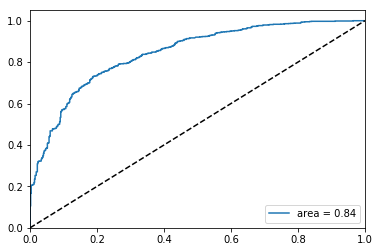

['SVC.pkl']

In [11]:
# """
# 2.1 SVM (RBF)
#     using training data with 100 dimensions
# """

# X_reduced_train = X[:]
# y_reduced_train = y[:]

# x_test_pos = X[pos_tran_num:int(len(posInput))]
# x_test_neg = X[(int(len(posInput))+neg_tran_num):]
# X_reduced_test = np.concatenate((x_test_pos,x_test_neg),axis = 0)
# y_test_pos = y[pos_tran_num:int(len(posInput))]
# y_test_neg = y[(int(len(posInput))+neg_tran_num):]
# y_reduced_test = np.concatenate((y_test_pos,y_test_neg),axis = 0)

print len(X_reduced_train)
print len(y_reduced_train)

clf = SVC(C = 2, probability = True)
clf.fit(X_reduced_train, y_reduced_train)

print 'Test Accuracy: %.2f'% clf.score(X_reduced_test, y_reduced_test)

pred_probas = clf.predict_proba(X_reduced_test)[:,1]
# print "KS value: %f" % KSmetric(y_reduced_test, pred_probas)[0]

# plot ROC curve
# AUC = 0.92
# KS = 0.7
fpr,tpr,_ = roc_curve(y_reduced_test, pred_probas)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, label = 'area = %.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc = 'lower right')
plt.show()

joblib.dump(clf, "SVC.pkl")

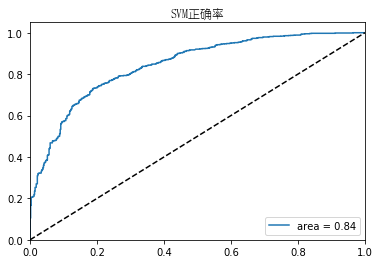

['SVC.pkl']

In [52]:
import matplotlib
fpr,tpr,_ = roc_curve(y_reduced_test, pred_probas)

font_file = "/usr/share/fonts/SIMYOU.TTF"
font_img_title = matplotlib.font_manager.FontProperties(fname=font_file, weight='bold', size='large')
# ax.set_title(u"断言覆盖率", fontproperties=font_img_title)

roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, label = 'area = %.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# plt.title(u"auccuracy of SVM")
plt.title(u"SVM正确率", fontproperties=font_img_title)
plt.legend(loc = 'lower right')
plt.savefig('SVM_acc_.eps')
plt.show()


joblib.dump(clf, "SVC.pkl")

In [47]:
from sklearn.externals import joblib

# save classifier
joblib.dump(clf, "Classifier_mood.pkl")
# load classifier
# clf = joblib.load("Classifier_mood.pkl")

['Classifier_mood.pkl']

In [68]:
comment_path = "./comment_part/"
import os
import re
import codecs
fileDir = os.listdir(comment_path)

model_vec = gensim.models.KeyedVectors.load_word2vec_format("corpus_xueqiu.model.bin", binary=True)

def getWordVecs(wordList):
    vecs = []
    for word in wordList:
        word = word.replace('\n', '')
        word = word.replace('\r', '')
        try:
            vecs.append(model_vec[word])
        except KeyError:
            continue
    # vecs = np.concatenate(vecs)
    return np.array(vecs, dtype = 'float')

def buildVecs_xueqiu(filename,tingyongci_list):
    posInput = [] 
    time_list = [] 
    with open(filename, "rb") as txtfile:
        # print txtfile
        for lines in txtfile:
            lines_s = lines.split('[,,,,,,]')
            pop_list = []
            time = lines_s[0]        
            line_s = jieba.cut(lines_s[1])
            for i in line_s:
#                     print type(i)
                if not i in tingyongci_list:
                    pop_list.append(i) #删除停用词
#             print " ".join(pop_list)
            
            resultList = getWordVecs(pop_list)
                # for each sentence, the mean vector of all its vectors is used to represent this sentence
            if len(resultList) != 0:
                resultArray = sum(np.array(resultList))/len(resultList)
                posInput.append(resultArray)
                time_list.append(lines_s[0])
    return posInput,time_list

def getcomment_time(filename):
    time_list = [] 
    with open(filename, "rb") as txtfile:
        # print txtfile
        for lines in txtfile:
            lines_s = lines.split('[,,,,,,]')
            pop_list = []
            time_list.append(lines_s[0])        
    return time_list


In [ ]:
import time
import tushare as ts
from sklearn.externals import joblib

def get_time_list_order(time_list):
    list_order = []
    key = [ "1","2"]
    for i in time_list:
        if i not in key:
            list_order.append(i)
            key.append(i)
        else:
            continue
    return list_order

def time_yester(time_str):
    return time.strftime('%Y-%m-%d', time.localtime(time.mktime(time.strptime(time_str,'%Y-%m-%d'))-60*60*24))
           

In [81]:
import pickle
# f1 = file('stock_data.pkl', 'r') 
# load_var = pickle.load(f1)
# f1.close() 
# mood_day_list_dir = np.array([])
# wave_day_list_dir = np.array([])
for filename_fileDir in [fileDir[18]]:
    print filename_fileDir
    filename_comment_test = comment_path+filename_fileDir
    a,time_list=buildVecs_xueqiu(filename_comment_test,tingyongci_list)
#     time_list = getcomment_time(filename_comment_test)
    # x = time.localtime(int(time_list[0])/1000.0)
    time_date = []
    for i in time_list:
        x = time.localtime(int(i)/1000.0)
        time_date.append(time.strftime('%Y-%m-%d',x))
    # print time_date
    stock_wave = []
    start_time = get_time_list_order(time_date)[0]
    end_time =get_time_list_order(time_date)[-1]
    stock_name = filename_fileDir[-10:-4]
    print stock_name
    stock_data = load_var[stock_name]
#     stock_data = ts.get_hist_data(stock_name,start="2016-4-01",end="2017-5-01")
    # print ts.get_hist_data(stock_name,start="2016-4-01",end=start_time)
    for i in range(len(stock_data)):
        try:
            if stock_data["close"][i] >  stock_data["close"][i+1]:
                stock_wave.append(1)
            else:
                stock_wave.append(0)
        except:
             stock_wave.append(0)
#     print  len(stock_data.index)
#     print len(stock_wave)
#     stock_data.insert(5,"stock_wave",stock_wave)
#     print stock_data["stock_wave"]["2017-03-21"]
#     print len(a[0])
    X_xueqiu = []
    y_xueqiu = []
    # print time_date[0:30]
    # print get_time_list_order(time_date)
#     end_time = time_yester(stock_data.index[-1])
#     for i in range(2):
#         end_time = time_yester(end_time)
    i_num = 0
    for i in time_date:
        if i in stock_data.index:
            for j in time_date[i_num:]:
                if j == i:
                    X_xueqiu.append(a[i_num])
                    y_xueqiu.append(stock_data["stock_wave"][j])
                    i_num += 1
        else:
            t = i
            while t not in stock_data.index and t !=end_time: 
                t = time_yester(t)
            if t in stock_data.index:
                for j in time_date[ i_num:]:
                    if j ==i:
                        X_xueqiu.append(a[i_num])
                        y_xueqiu.append(stock_data["stock_wave"][t])
                        i_num += 1
            else:
                break
    clf = joblib.load("Classifier_mood.pkl")
    pred_probas = clf.predict_proba(X_xueqiu)[:,1]
    end_time = time_yester(stock_data.index[-1])
    i_num = 0
    x_xueqiu_len = len(X_xueqiu)
    same_date = " "
    same_date_list = [ ]
    count_i = 0
    mood_day_list = []
    wave_day_list = []
    for i in time_date[:x_xueqiu_len]:
        if i != same_date:
            if count_i != 0:
                same_date_list = np.array(same_date_list)
                mood_day_list.append(sum(same_date_list)/len(same_date_list))
                if same_date in stock_data.index:
                    wave_day_list.append(stock_data["stock_wave"][same_date])
                else:
                    t = same_date
                    while t not in stock_data.index and t !=end_time: 
                        t = time_yester(t)
                    if t != end_time:
                        wave_day_list.append(stock_data["stock_wave"][t])               
            same_date = i
            same_date_list = [ ]
            same_date_list.append(pred_probas[count_i])
        else:
             same_date_list.append(pred_probas[count_i])
        count_i += 1
        
    mood_day_list = np.array(mood_day_list)
    wave_day_list = np.array(wave_day_list)
    mood_day_list_dir = np.concatenate((mood_day_list_dir,mood_day_list),axis = 0)
    wave_day_list_dir = np.concatenate((wave_day_list_dir,wave_day_list),axis = 0)
 

xueqiu_comment_SZ300104.txt
300104


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.

In [85]:
print len(a)

908


1131
1131
Test Accuracy: 0.48


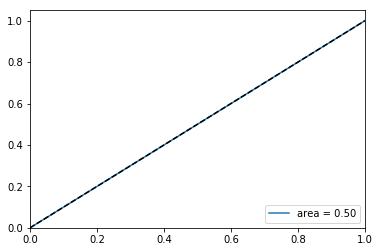

['Classifier_wave.pkl']

In [86]:
# """
# 2.1 SVM (RBF)
#     using training data with 100 dimensions
# """

mood_day_list_dir_tra = []
for i in mood_day_list_dir:
    mood_day_list_dir_tra.append([i])
X_reduced_train_num = int(0.8*len(mood_day_list_dir_tra))
y_reduced_train_num = int(0.8*len(wave_day_list_dir))

X_reduced_train = mood_day_list_dir_tra[:]
y_reduced_train = wave_day_list_dir[:]
X_reduced_test = mood_day_list_dir_tra[X_reduced_train_num:]
y_reduced_test = wave_day_list_dir[y_reduced_train_num:]

print len(X_reduced_train)
print len(y_reduced_train)

clf = SVC(C = 2, probability = True)
clf.fit(X_reduced_train, y_reduced_train)

print 'Test Accuracy: %.2f'% clf.score(X_reduced_test, y_reduced_test)

pred_probas = clf.predict_proba(X_reduced_test)[:,1]
# print "KS value: %f" % KSmetric(y_reduced_test, pred_probas)[0]

# plot ROC curve
# AUC = 0.92
# KS = 0.7
fpr,tpr,_ = roc_curve(y_reduced_test, pred_probas)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, label = 'area = %.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc = 'lower right')
plt.show()

from sklearn.externals import joblib

# save classifier
joblib.dump(clf, "Classifier_wave.pkl")
# load classifier
# clf = joblib.load("Classifier_mood.pkl")

72
72
0
400


2017-01-02
661
661
936


In [40]:
# pca=PCA(n_components=100)
# X = np.array(X_xueqiu)
# X = scale(X)
# pca.fit(X)
# plt.figure(1, figsize=(4, 3))
# plt.clf()
# plt.axes([.2, .2, .7, .7])
# plt.plot(pca.explained_variance_, linewidth=2)
# plt.axis('tight')
# plt.xlabel('n_components')
# plt.ylabel('explained_variance_')
# plt.show()

# X_xueqiu_reduced = PCA(n_components = 20).fit_transform(X)

# print "KS value: %f" % KSmetric(y_reduced_test, pred_probas)[0]

# plot ROC curve
# AUC = 0.92
# KS = 0.7

# fpr,tpr,_ = roc_curve(y_xueqiu, pred_probas)
# roc_auc = auc(fpr,tpr)
# plt.plot(fpr, tpr, label = 'area = %.2f' % roc_auc)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.legend(loc = 'lower right')
# plt.show()

# joblib.dump(clf, "SVC.pkl")

661
661


In [46]:
# print pred_probas
# print time_date[0:30]
# print get_time_list_order(time_date)

        

            

83
83


In [ ]:
np.array